In [1]:
import ppptm as gptm
import optax
import liesel.goose as gs
from liesel_ptm.util.plots import plot_loss, plot_param_history
import tensorflow_probability.substrates.jax.distributions as tfd
import jax.numpy as jnp

In [2]:
def opt1():
    # Define the learning rate scheduler
    scheduler = optax.cosine_decay_schedule(init_value=0.01, decay_steps=2000)

    # Define the AdamW optimizer with weight decay
    adamw_optimizer = optax.adamw(learning_rate=scheduler, weight_decay=1e-4)

    gradient_clipping = optax.clip_by_global_norm(1.0)

    # Combine them using optax.chain
    combined_optimizer = optax.chain(gradient_clipping, adamw_optimizer)
    return combined_optimizer

In [3]:
data = gptm.load_americas()

In [4]:
locs = gptm.LocationVars.new_from(data.locs, n_subset=256)
y = data.obs[:, locs.locs.ordering]
model = gptm.Model.new_HG(
    y,
    locs,
    g_dist=gptm.G(y, locs, ard=True).new_gaussian(),
    coef=gptm.H(
        locs,
        ard=True,
        locwise_amplitude=True,
        # amplitude_prior=lsl.Dist(
        #     tfd.Weibull, concentration=jnp.array(0.5), scale=jnp.array(0.5)
        # ),
    ).new_coef(),
)

In [5]:
result = model.fit(
    stopper=gs.Stopper(max_iter=2_000, patience=30),
    optimizer=opt1(),
    progress_bar=True,
)

Training loss: 426964.688, Validation loss: 426964.656:  16%|█▌        | 322/2000 [00:21<01:52, 14.89it/s]

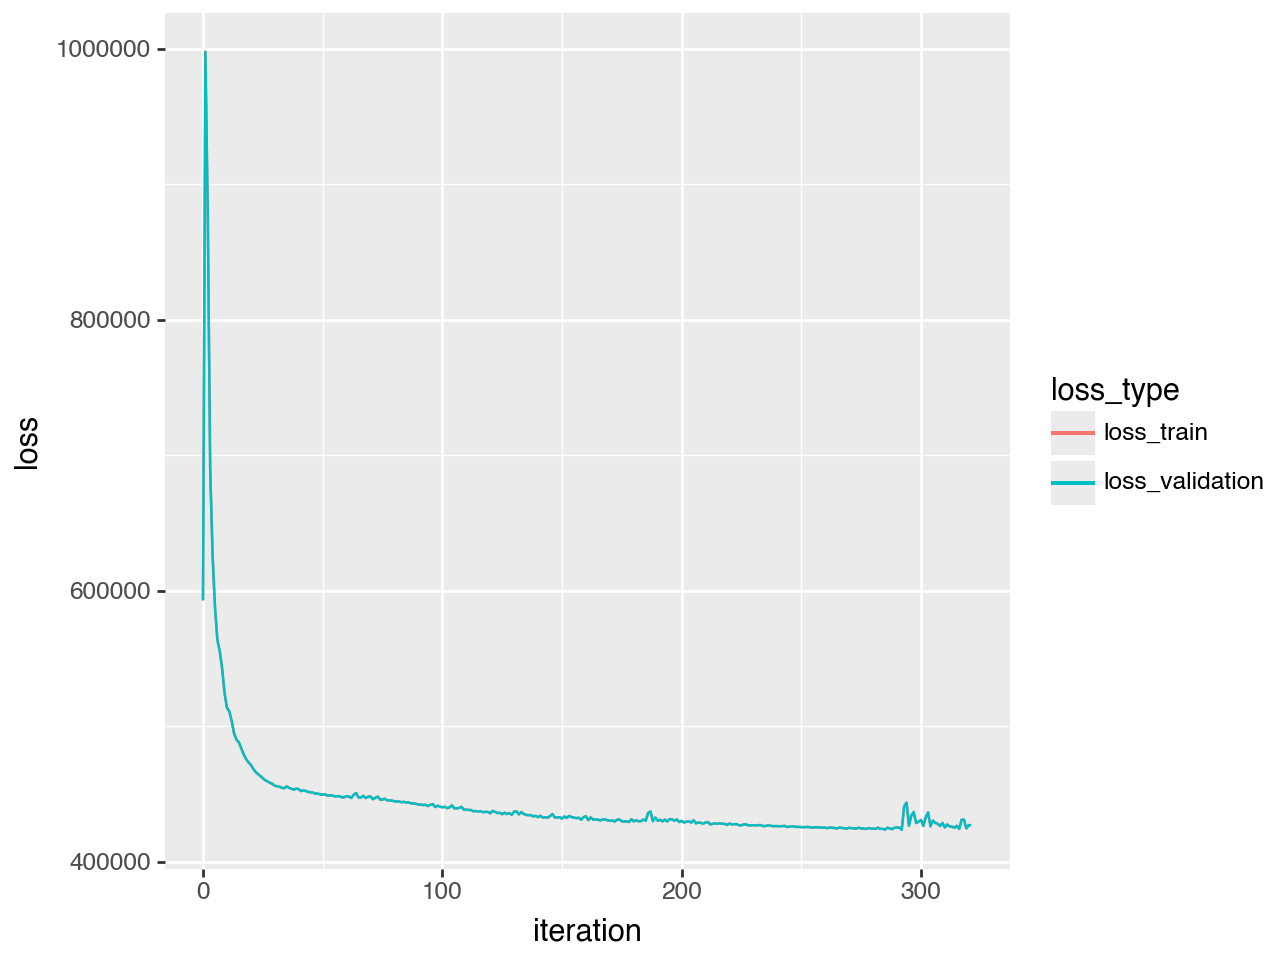

In [6]:
plot_loss(result)

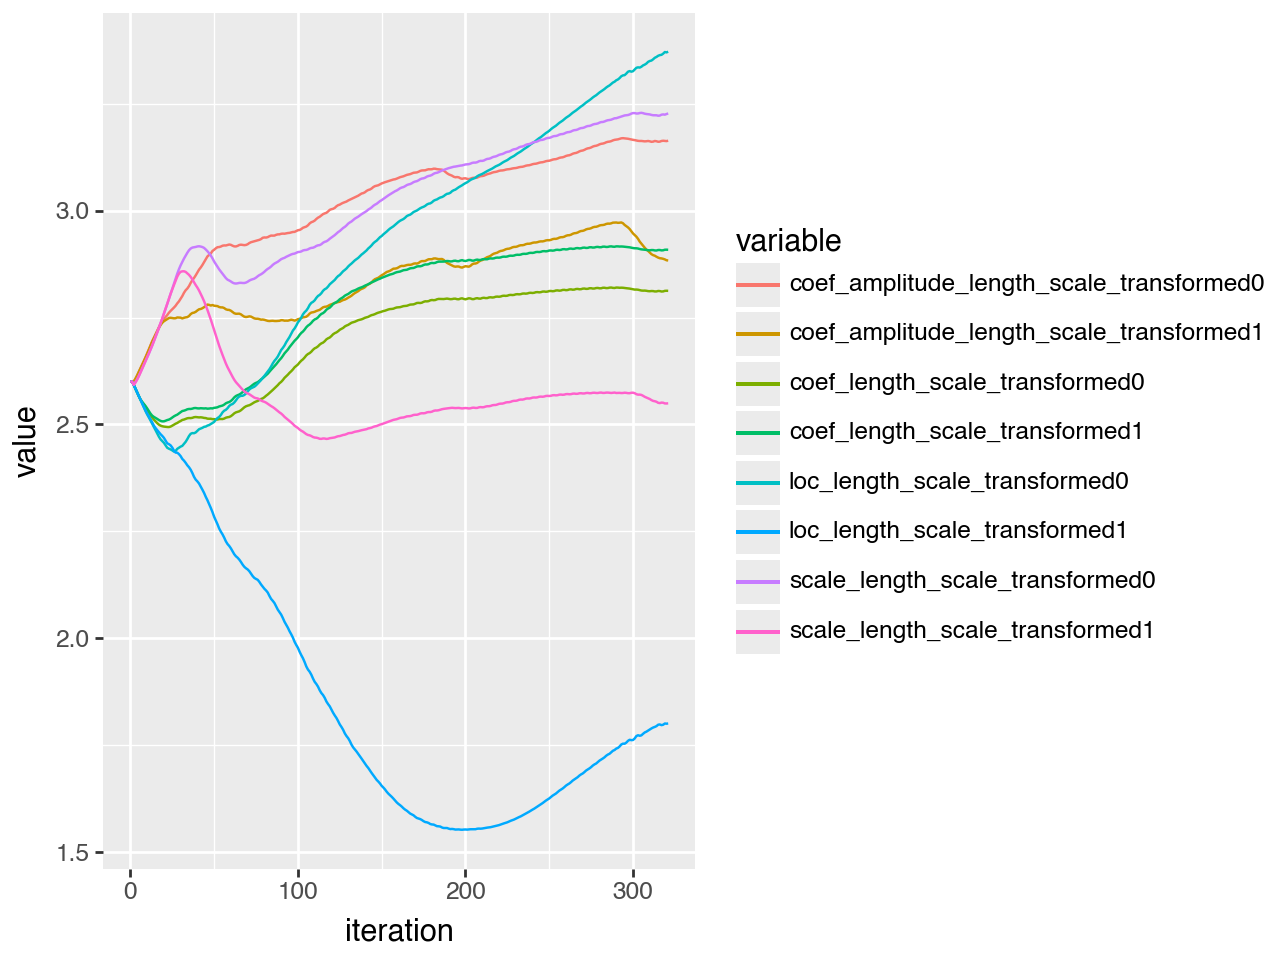

In [7]:
d = {k: v for k, v in result.history["position"].items() if "length_scale" in k}
plot_param_history(d)

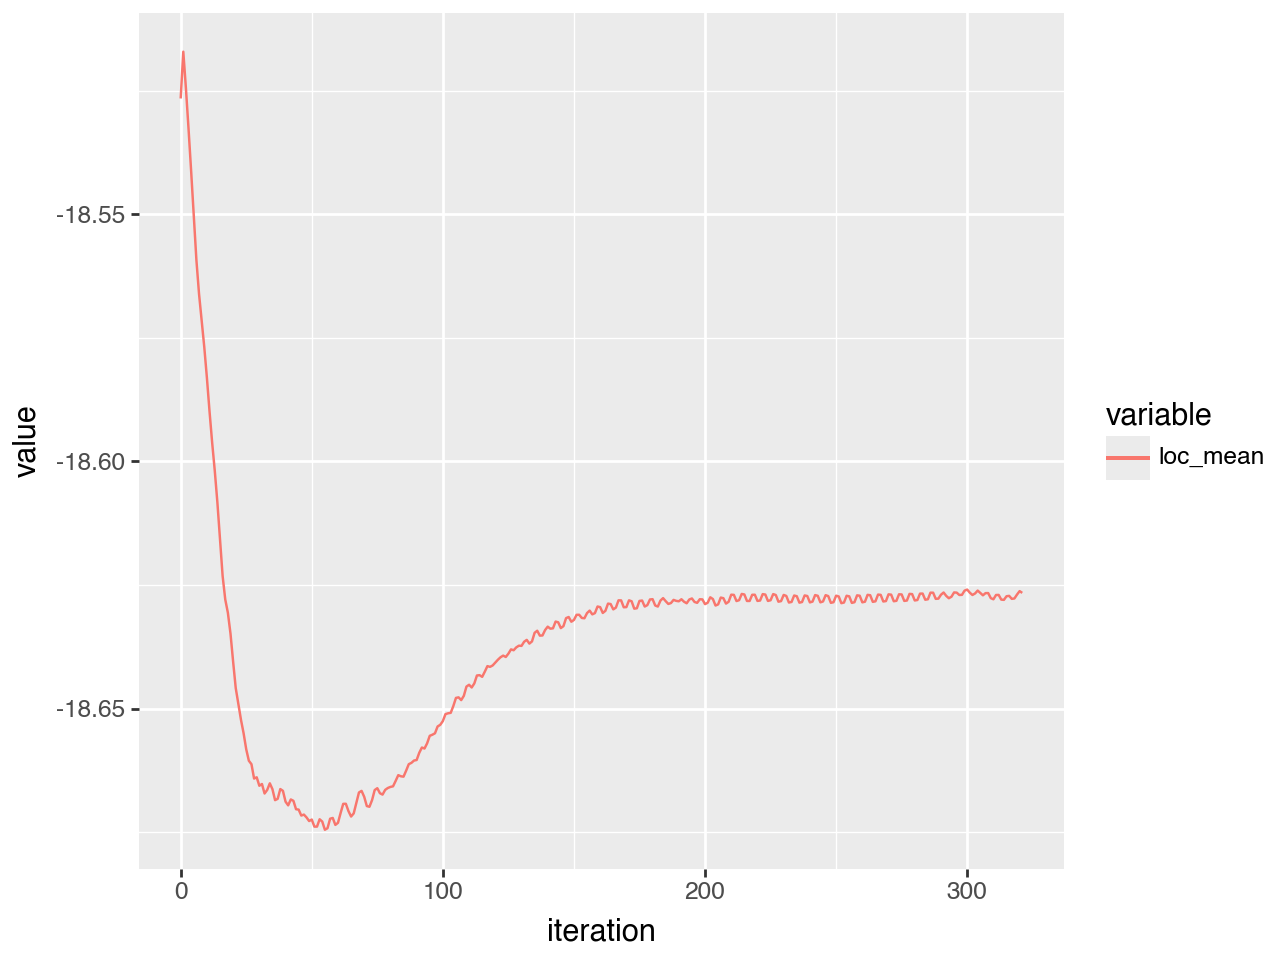

In [8]:
d = {k: v for k, v in result.history["position"].items() if "loc_mean" in k}
plot_param_history(d)

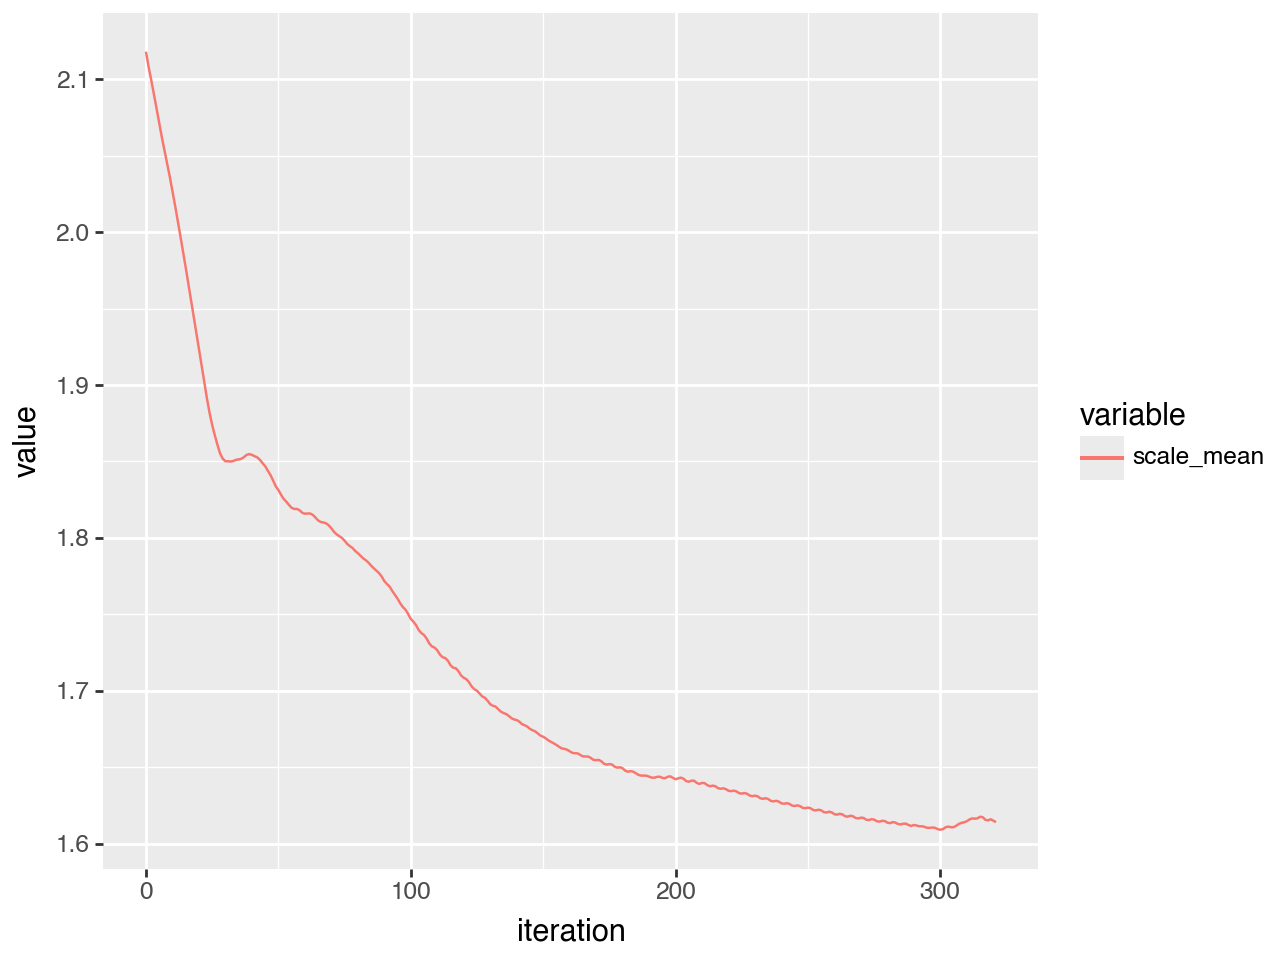

In [9]:
d = {k: v for k, v in result.history["position"].items() if "scale_mean" in k}
plot_param_history(d)

In [10]:
df = gptm.long_df_multiple(
    locs.locs.ordered,
    mu=model.graph.vars["loc"].value,
    sigma=model.graph.vars["scale"].value,
)

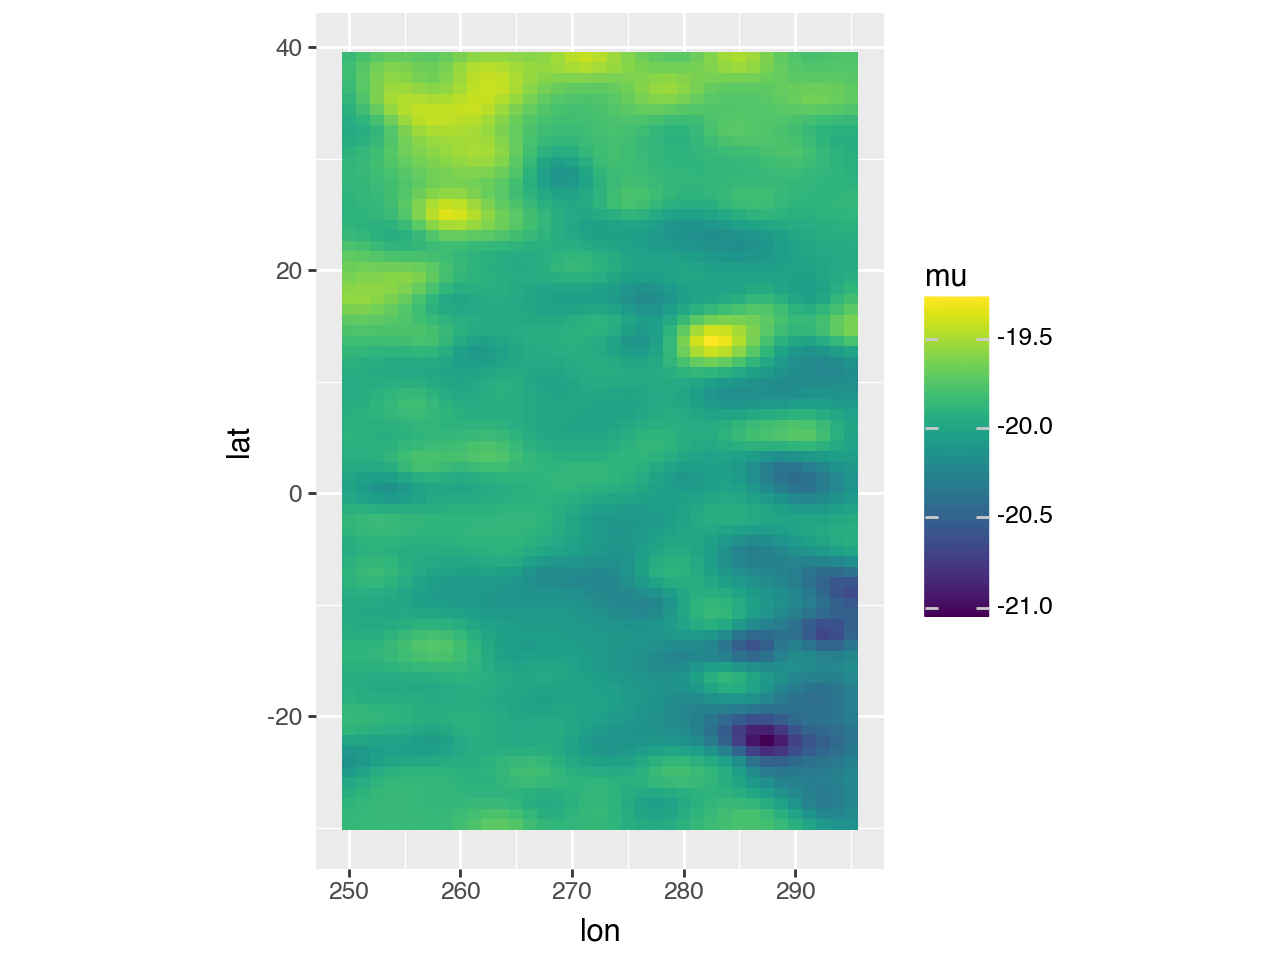

In [11]:
gptm.plot_df(df, "mu")

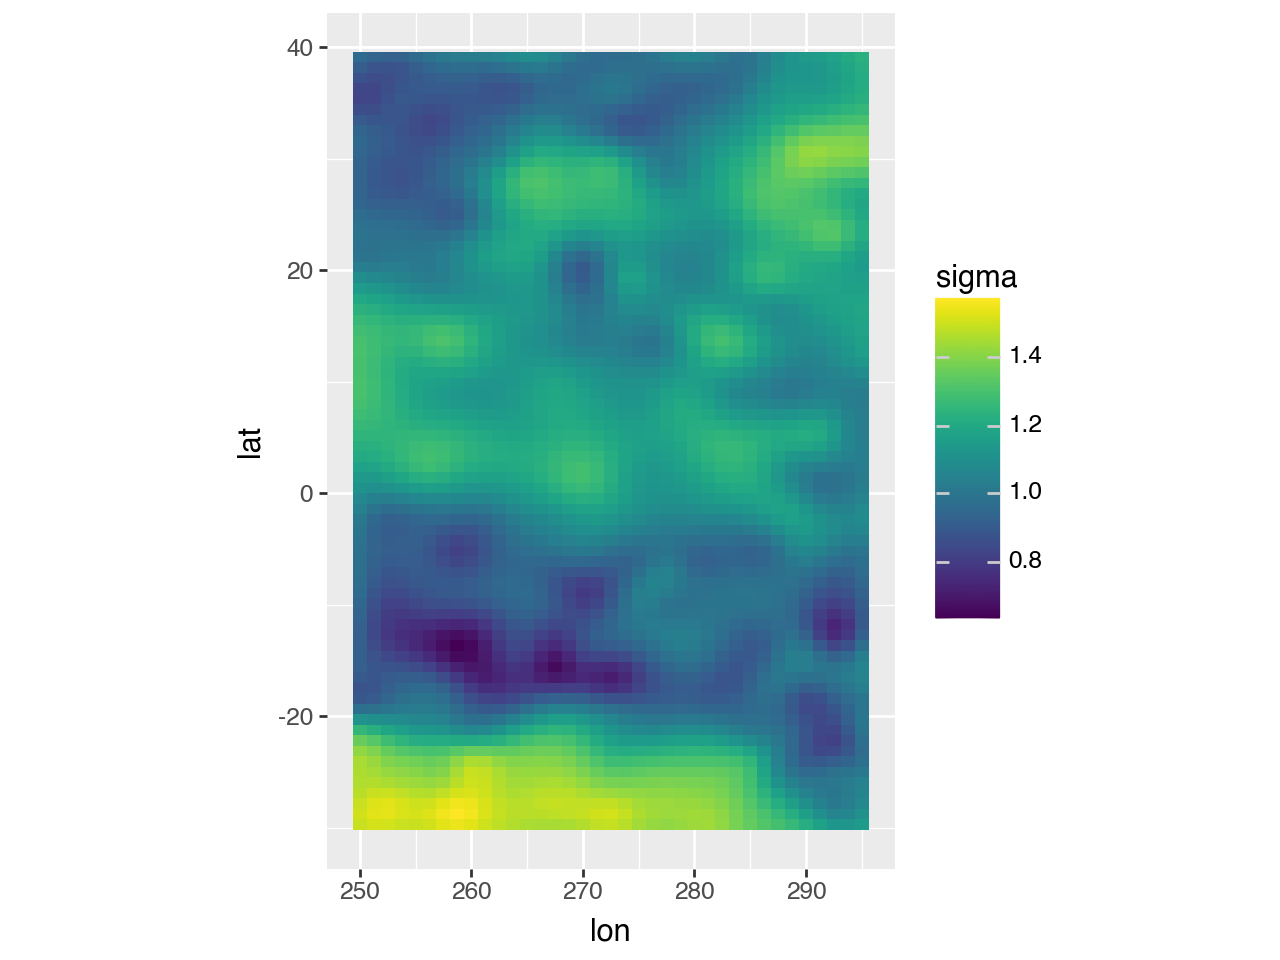

In [12]:
gptm.plot_df(df, "sigma")

In [13]:
model.coef.value.shape

(2738, 40)

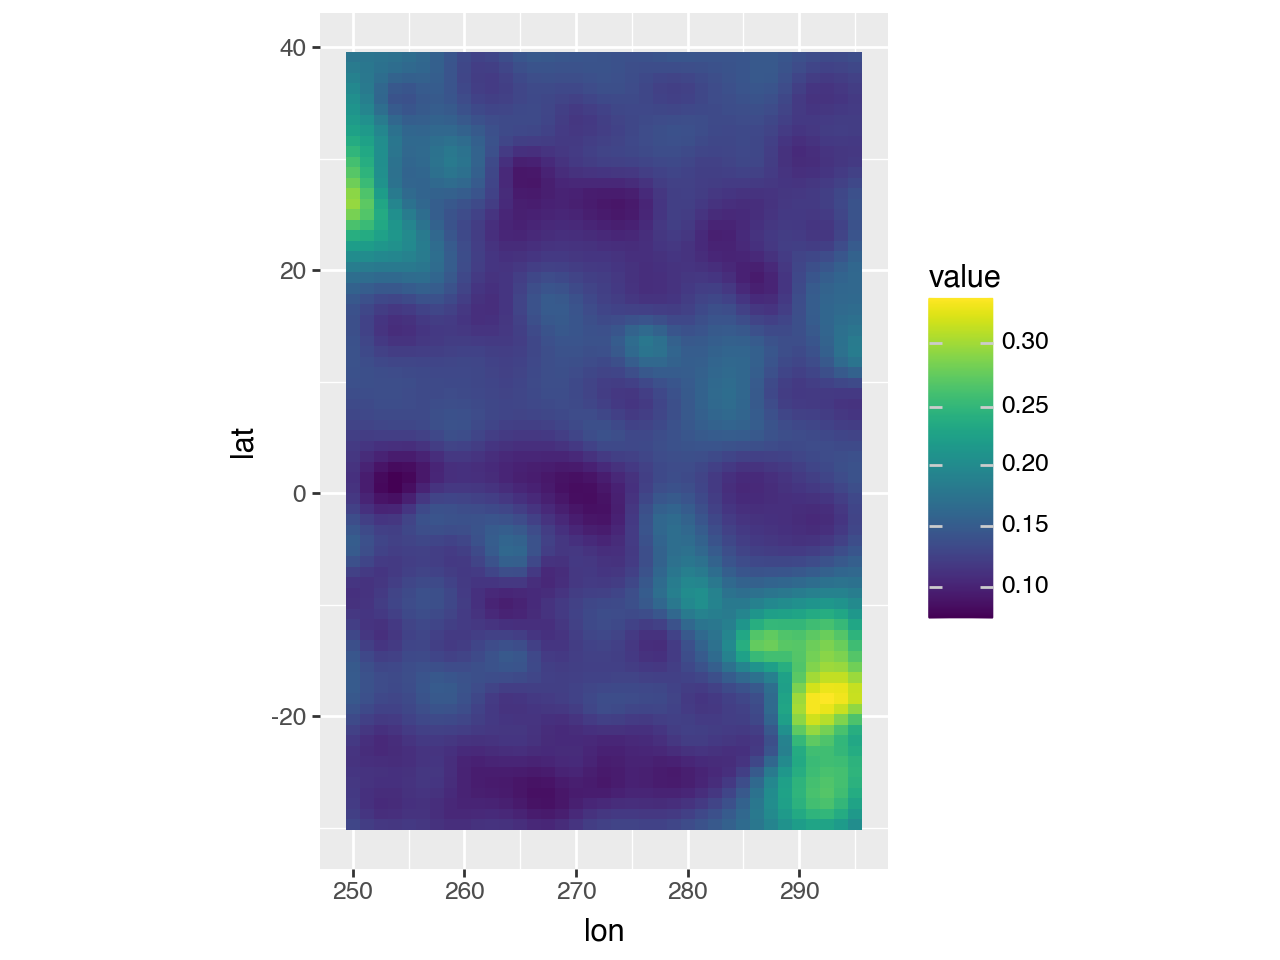

In [14]:
df = gptm.long_df(locs.locs.ordered, model.coef.amplitude.value)
gptm.plot_df(df)

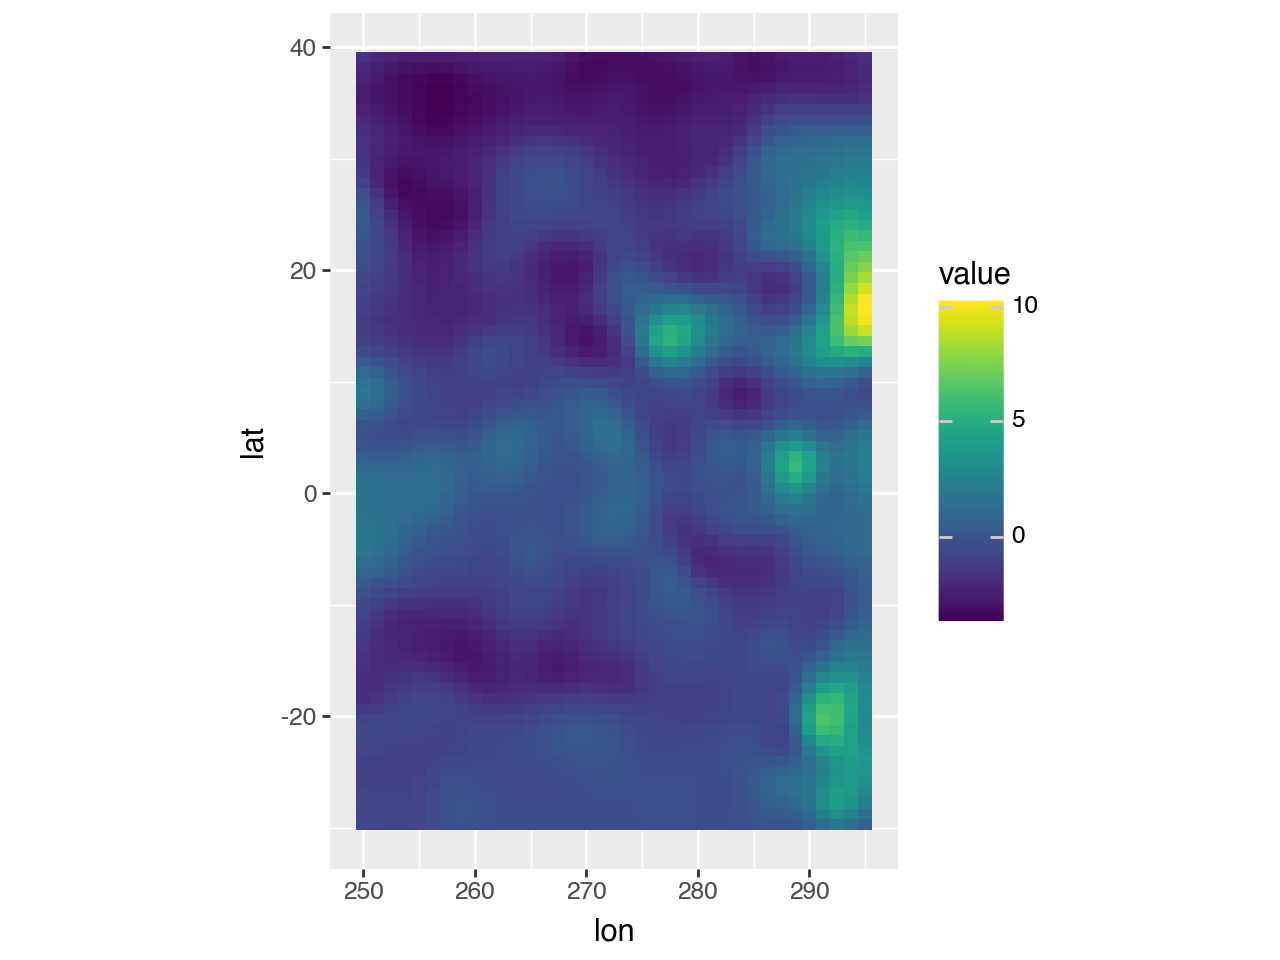

In [15]:
df = gptm.long_df(locs.locs.ordered, model.coef.value.T)
gptm.plot_df(df.query("obs == 20"))

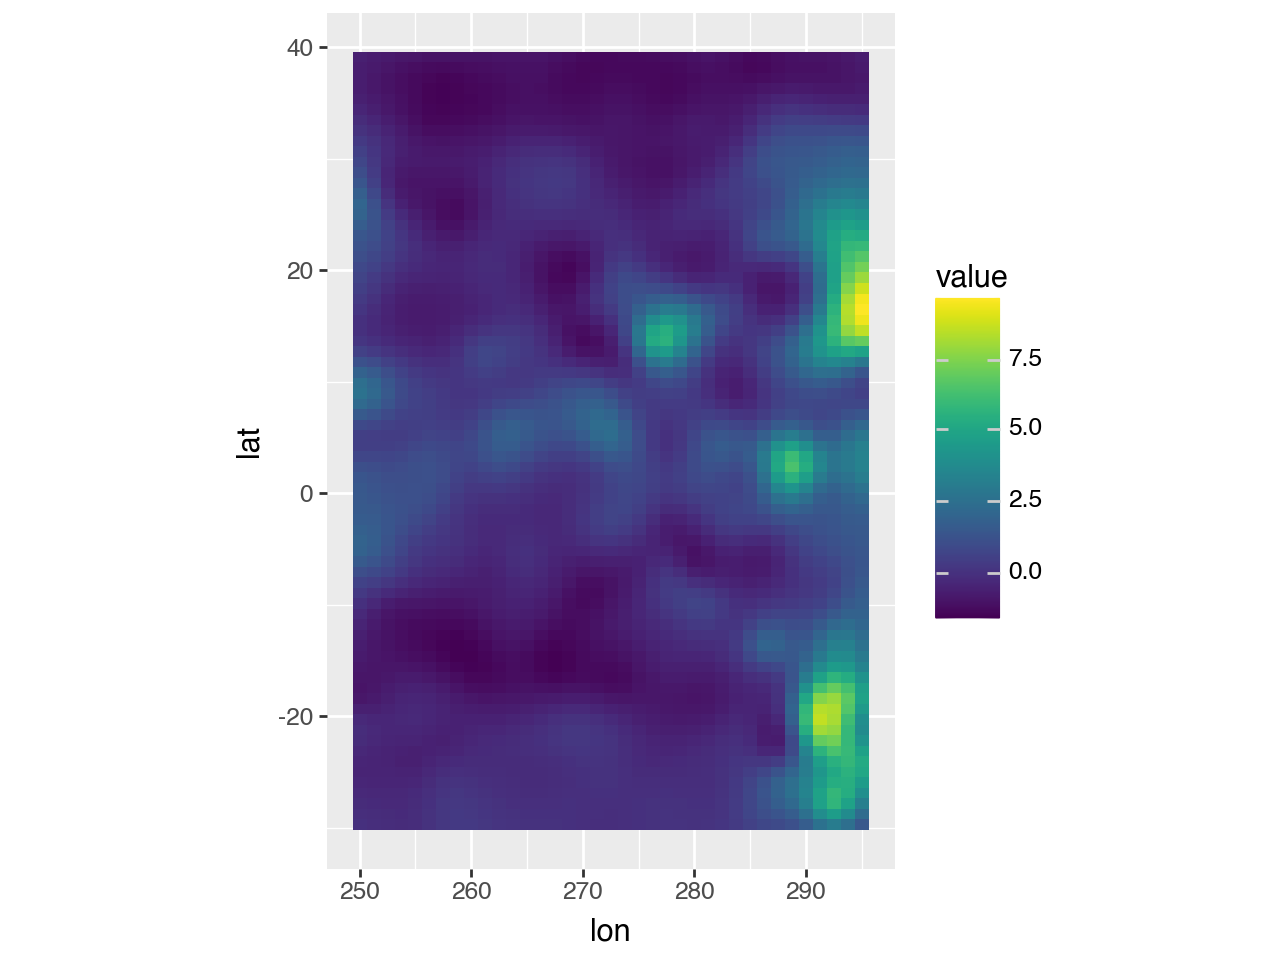

In [16]:
gptm.plot_df(df.query("obs == 30"))

In [159]:
from jax.random import key

samp = model.init_dist().sample((500), seed=key(2))

In [190]:
m = samp.mean(
    axis=0, keepdims=True
)  # - model.init_dist().parametric_distribution.mean()
s = samp.std(
    axis=0, keepdims=True
)  # / model.init_dist().parametric_distribution.stddev()

In [191]:
model.init_dist().parametric_distribution.mean()

Array([-19.990583, -19.863167, -20.129827, ..., -19.662245, -19.6749  ,
       -19.700409], dtype=float32)

In [192]:
m

Array([[-15.705803, -17.634247, -21.422165, ..., -17.573172, -17.780048,
        -17.91863 ]], dtype=float32)

In [193]:
grid = jnp.linspace(-6.0, 6.0, 301)
grid = jnp.expand_dims(grid, -1)
grid = jnp.tile(grid, locs.locs.nloc)

In [194]:
grid2 = s * grid + m
logdet1 = jnp.log(s)
zt, logdet2 = model.init_dist().transformation_and_logdet(grid2)
lp = tfd.Normal(loc=0.0, scale=1.0).log_prob(zt) + logdet1 + logdet2
pdf = jnp.exp(lp)

df = gptm.long_df_multiple(locs.locs.ordered, pdf=pdf, grid=grid, zt=zt, grid2=grid2)
df

,loc,lon,lat,obs,pdf,grid,zt,grid2
0,0,272.50,5.183246,0,1.557705e-04,-6.0,-3.719033,-19.952515
1,1,250.00,-29.685864,0,5.525584e-07,-6.0,-5.220721,-27.907135
2,2,295.00,-29.685864,0,1.016718e-21,-6.0,-9.775959,-31.361305
3,3,250.00,39.109948,0,0.000000e+00,-6.0,-12.949954,-32.810120
4,4,295.00,39.109948,0,2.697475e-17,-6.0,-8.690462,-30.477243
...,...,...,...,...,...,...,...,...
824133,2733,288.75,36.282723,300,2.558484e-30,6.0,3.557863,-5.666670
824134,2734,290.00,36.282723,300,5.242379e-32,6.0,3.605245,-5.324310
824135,2735,291.25,36.282723,300,8.756961e-31,6.0,3.673607,-5.567562
824136,2736,293.75,36.282723,300,1.117222e-26,6.0,3.839296,-6.040416


In [195]:
y2 = (y - y.mean(axis=0, keepdims=True)) / y.std(axis=0, keepdims=True)
df2 = gptm.long_df(locs.locs.ordered, y2)

In [196]:
df2

,loc,lon,lat,obs,value
0,0,272.50,5.183246,0,0.971940
1,1,250.00,-29.685864,0,-0.336684
2,2,295.00,-29.685864,0,0.548288
3,3,250.00,39.109948,0,-1.132898
4,4,295.00,39.109948,0,-0.753818
...,...,...,...,...,...
268319,2733,288.75,36.282723,97,-0.361694
268320,2734,290.00,36.282723,97,-0.453360
268321,2735,291.25,36.282723,97,-0.324780
268322,2736,293.75,36.282723,97,-0.854244


In [197]:
samp.mean(axis=0, keepdims=True)

Array([[-15.705803, -17.634247, -21.422165, ..., -17.573172, -17.780048,
        -17.91863 ]], dtype=float32)

In [198]:
y.mean(axis=0)

array([-15.830548  , -17.86376215, -21.74290467, ..., -17.77166088,
       -17.89706544, -17.86423473], shape=(2738,))

In [199]:
y2.mean(axis=0)

array([-3.27629080e-15, -3.94667292e-16, -1.35945676e-16, ...,
        1.84659544e-16,  3.94242462e-16,  4.75809868e-16], shape=(2738,))

In [200]:
m

Array([[-15.705803, -17.634247, -21.422165, ..., -17.573172, -17.780048,
        -17.91863 ]], dtype=float32)

In [201]:
y.std(axis=0)

array([0.76114801, 1.77431248, 1.48544568, ..., 2.08072967, 2.02501945,
       1.89654612], shape=(2738,))

In [202]:
samp.std(axis=0)

Array([0.7077854, 1.7121478, 1.6565235, ..., 2.0009348, 1.9566054,
       1.9765693], dtype=float32)

In [203]:
s

Array([[0.7077854, 1.7121478, 1.6565235, ..., 2.0009348, 1.9566054,
        1.9765693]], dtype=float32)

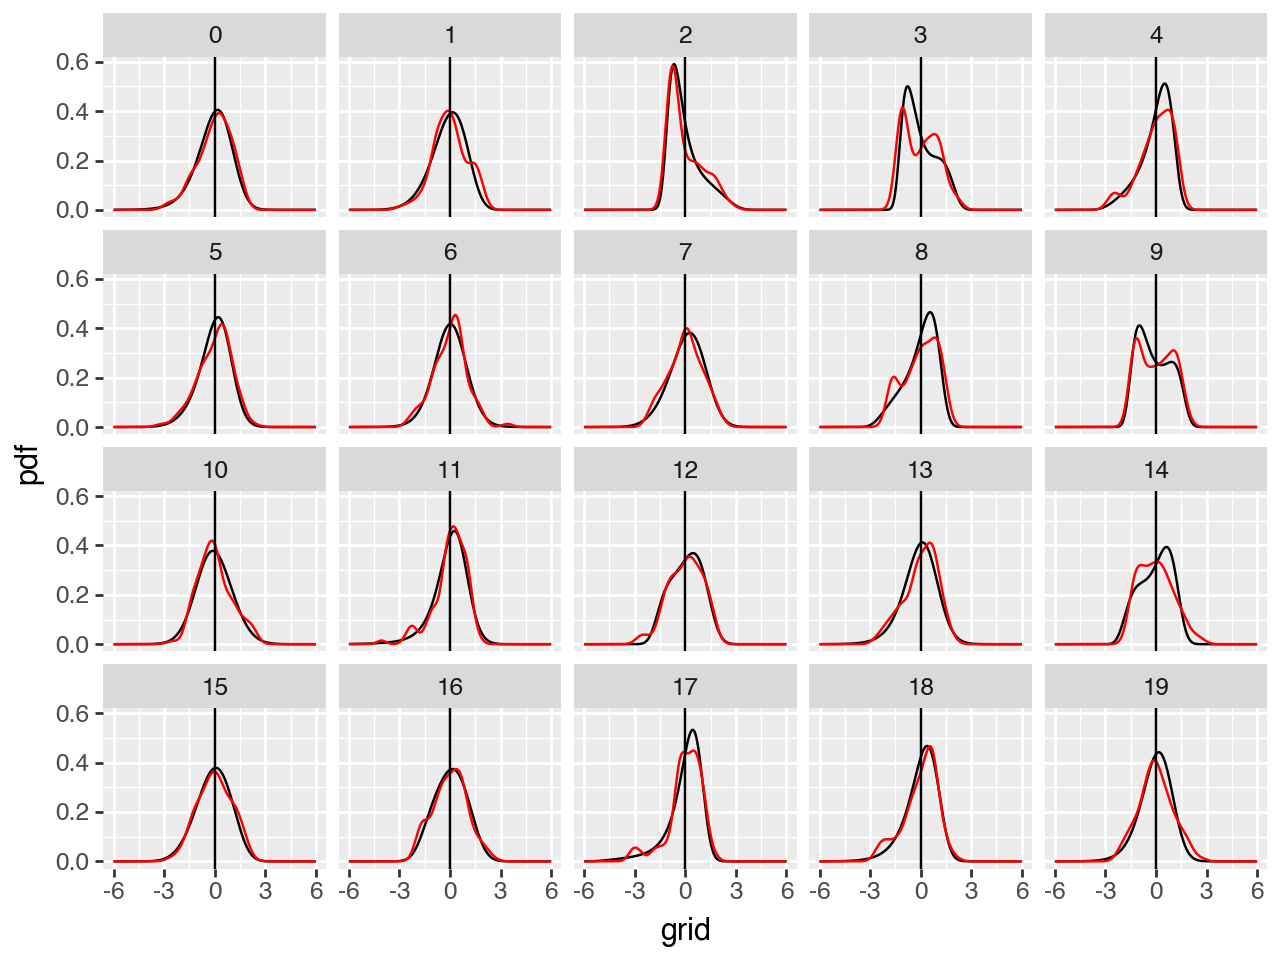

In [204]:
import plotnine as p9

(
    p9.ggplot(df.query("loc < 20"))
    + p9.geom_line(p9.aes("grid", "pdf"))
    + p9.geom_density(p9.aes("value"), color="red", data=df2.query("loc < 20"))
    + p9.geom_vline(p9.aes(xintercept=0.0))
    + p9.facet_wrap("~loc")
    # + p9.xlim((-5.0, 5.0))
)

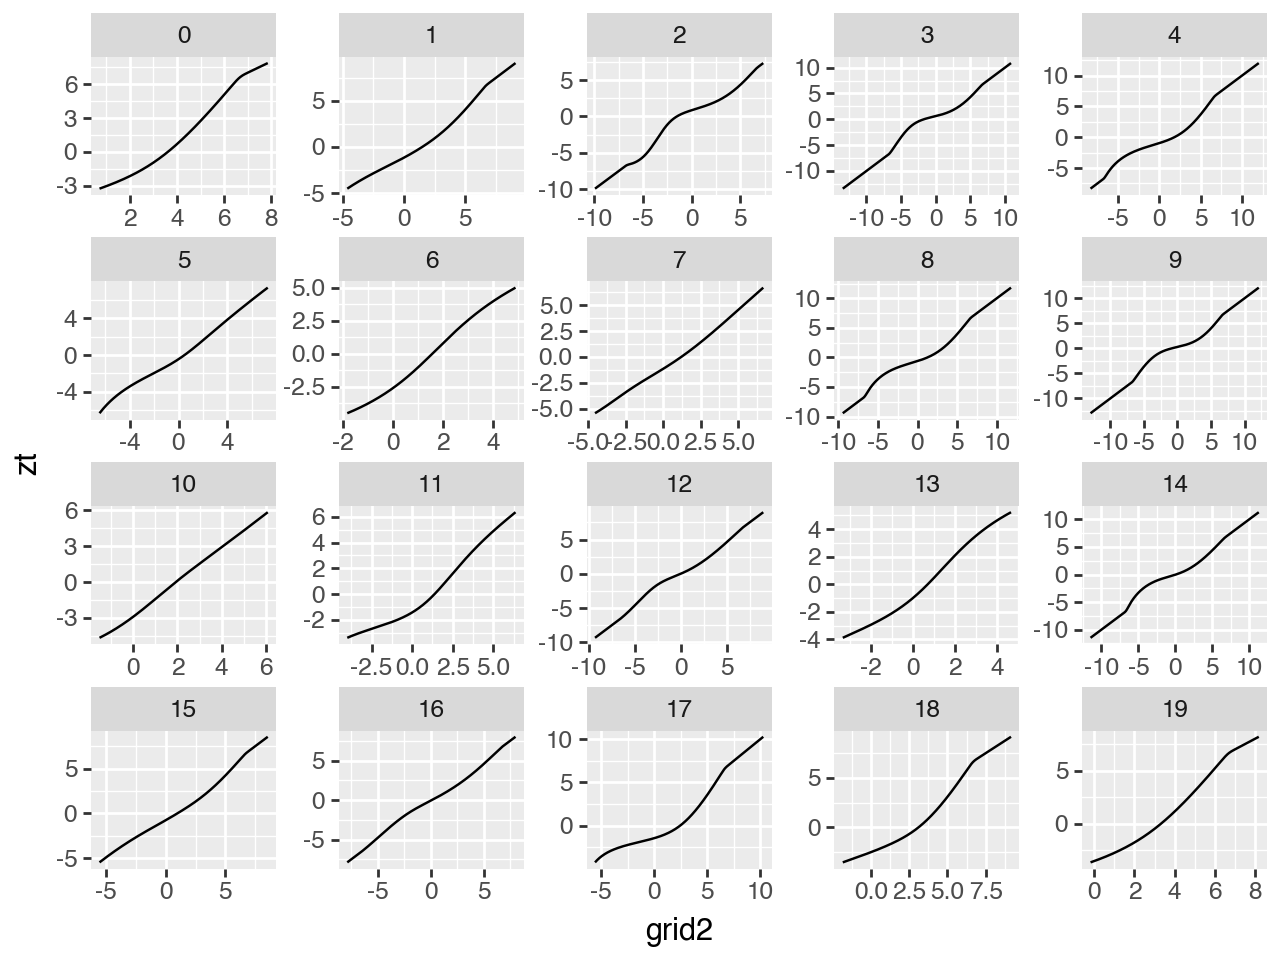

In [180]:
import plotnine as p9

(
    p9.ggplot(df.query("loc < 20"))
    + p9.geom_line(p9.aes("grid2", "zt"))
    + p9.facet_wrap("~loc", scales="free")
    # + p9.xlim((-5.0, 5.0))
)

In [155]:
pdf = jnp.exp(model.log_prob(y))
df = gptm.long_df_multiple(locs.locs.ordered, pdf=pdf, y=y)
df

,loc,lon,lat,obs,pdf,y
0,0,272.50,5.183246,0,0.424040,-15.090758
1,1,250.00,-29.685864,0,0.191786,-18.461144
2,2,295.00,-29.685864,0,0.154902,-20.928452
3,3,250.00,39.109948,0,0.232444,-23.025851
4,4,295.00,39.109948,0,0.110265,-19.240063
...,...,...,...,...,...,...
268319,2733,288.75,36.282723,97,0.125411,-18.124358
268320,2734,290.00,36.282723,97,0.109053,-18.442058
268321,2735,291.25,36.282723,97,0.115886,-18.447441
268322,2736,293.75,36.282723,97,0.080289,-19.626927


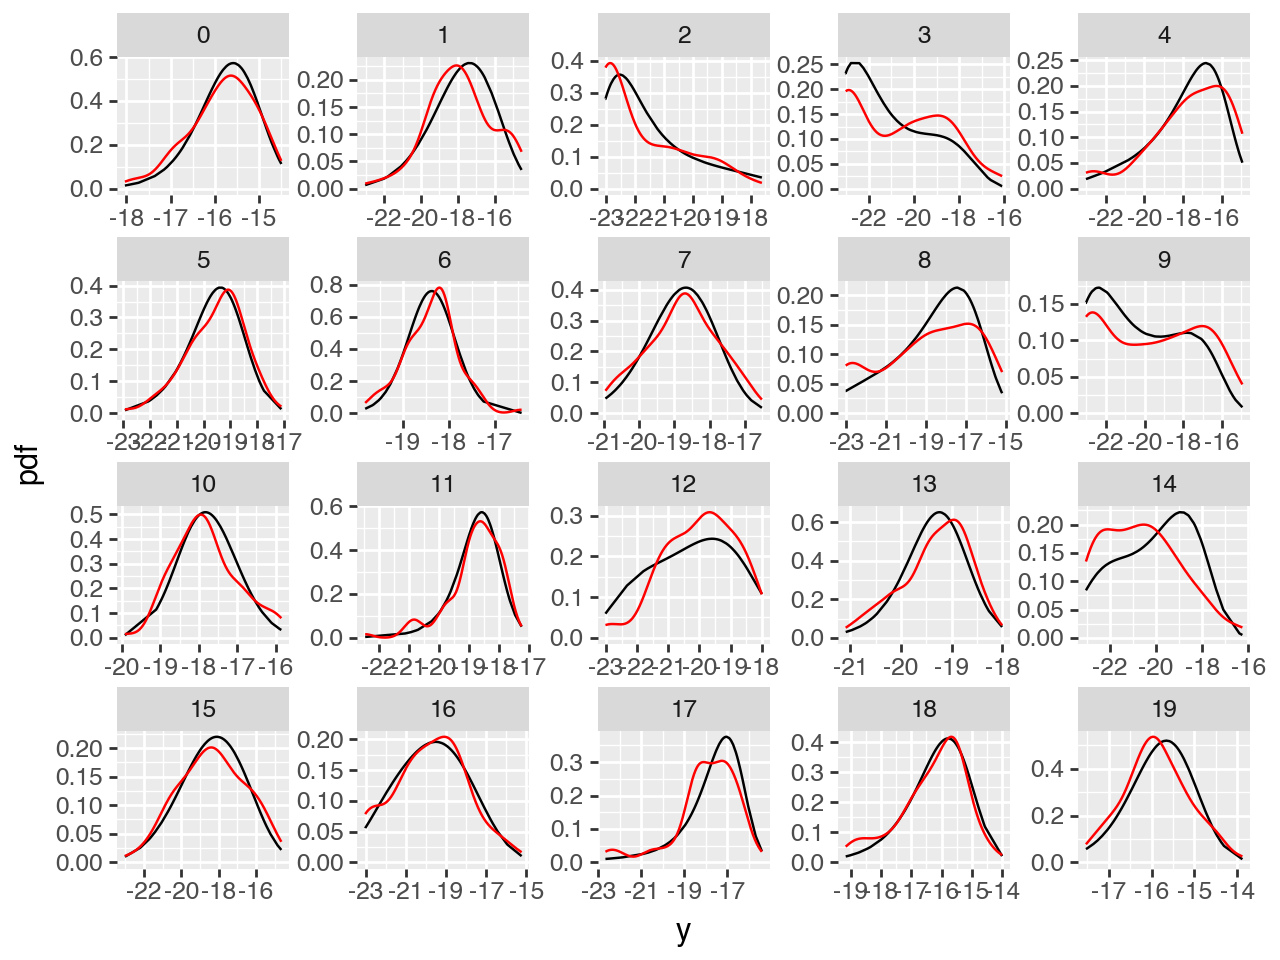

In [157]:
(
    p9.ggplot(df.query("loc < 20"))
    + p9.geom_line(p9.aes("y", "pdf"))
    + p9.geom_density(p9.aes("y"), color="red")
    + p9.facet_wrap("~loc", scales="free")
    # + p9.xlim((-5.0, 5.0))
)